In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline
sns.set(color_codes=True)

In [ ]:
# TODO: change this to yours ...
#DATA_DIR = "/Users/kwongtszkong/Desktop/STAT3612 Statistical ML/Group Project/Stat3612_Project_datasource"

# read 3 csv files and 1 pkl file
train_csv_file = os.path.join('/content', 'train.csv') # 使用绝对路径 '/content' 更明确
val_csv_file = os.path.join('/content', 'valid.csv')
test_csv_file = os.path.join('/content', 'test.csv')
ehr_pkl_file = os.path.join('/content', 'ehr_preprocessed_seq_by_day_cat_embedding.pkl')

train_df = pd.read_csv(train_csv_file)
val_df = pd.read_csv(val_csv_file)
test_df = pd.read_csv(test_csv_file)

with open(ehr_pkl_file, 'rb') as f:
    ehr_data = pd.read_pickle(f)

In [ ]:
#Option1 : Aggregate features by mean over the days



# Extract EHR features and IDs
ehr_features = ehr_data["feat_dict"]
ehr_ids = list(ehr_features.keys())

# Convert to DataFrame (each row is an admission)
ehr_df = pd.DataFrame({
    "id": ehr_ids,
    "ehr_matrix": [ehr_features[id] for id in ehr_ids]
})

# Merge with labels from train/val/test DataFrames
def merge_labels(df, ehr_df):
    return df[["id", "readmitted_within_30days"]].merge(ehr_df, on="id", how="inner")

train_ehr = merge_labels(train_df, ehr_df)
val_ehr = merge_labels(val_df, ehr_df)


def aggregate_ehr(df):
    # Aggregate features (example: mean over days)
    df["ehr_mean"] = df["ehr_matrix"].apply(lambda x: np.mean(x, axis=0))

    # Convert to numpy arrays
    X = np.stack(df["ehr_mean"].values)
    y = df["readmitted_within_30days"].astype(int).values

    return X, y

X_train, y_train = aggregate_ehr(train_ehr)
X_val, y_val = aggregate_ehr(val_ehr)


In [ ]:
#Option 2 Aggregate features by last day
"""
X_train = []
for idx, row in train_df.iterrows():
    X_train.append(ehr_data["feat_dict"][row["id"]][-1])
X_train = np.array(X_train)
print(X_train.shape)
print('train_data:',X_train,'\n')

X_val = []
for idx, row in val_df.iterrows():
    X_val.append(ehr_data["feat_dict"][row["id"]][-1])
X_val = np.array(X_val)
print(X_val.shape)
print('validation_data:,',X_val,'\n')




y_train = train_df['readmitted_within_30days'].values
y_val = val_df['readmitted_within_30days'].values

"""

'\nX_train = []\nfor idx, row in train_df.iterrows():\n    X_train.append(ehr_data["feat_dict"][row["id"]][-1])\nX_train = np.array(X_train)\nprint(X_train.shape)\nprint(\'train_data:\',X_train,\'\n\')\n\nX_val = []\nfor idx, row in val_df.iterrows():\n    X_val.append(ehr_data["feat_dict"][row["id"]][-1])\nX_val = np.array(X_val)\nprint(X_val.shape)\nprint(\'validation_data:,\',X_val,\'\n\')\n\n\n\n\ny_train = train_df[\'readmitted_within_30days\'].values\ny_val = val_df[\'readmitted_within_30days\'].values\n\n'

In [ ]:
from scipy.stats import pointbiserialr
# initialize storage for std_devs
std_devs = np.std(X_train, axis=0)


feature_names = ehr_data["feature_cols"]

# Create a DataFrame for analysis
std_df = pd.DataFrame({
    "Feature": feature_names,
    "Std_Dev": std_devs
})



# Initialize storage
correlations = []
p_values = []


# Calculate correlation for each feature
for i in range(X_train.shape[1]):
    if np.std(X_train[:, i]) == 0:  # Skip constant features
        correlations.append(0)
        p_values.append(1)
    else:
        corr, pval = pointbiserialr(X_train[:, i], y_train)
        correlations.append(corr)
        p_values.append(pval)



# Create results DataFrame
corr_df = pd.DataFrame({
    "Feature": feature_names,
    "Correlation": correlations,
    "P-value": p_values
})



# Sort by absolute correlation strength
corr_df["Abs_Correlation"] = np.abs(corr_df["Correlation"])
corr_df = corr_df.sort_values("Abs_Correlation", ascending=True)



# Function to analyze zero-value ratio in features
def analyze_zeros(ehr_data, feature_cols, threshold=0.5):

    all_zeros = []
    for feature_name, feature_idx in zip(feature_cols, range(len(feature_cols))):
        zeros_count = np.sum([np.sum(matrix[:, feature_idx] == 0) for matrix in ehr_data["feat_dict"].values()])
        total_values = sum([matrix.shape[0] for matrix in ehr_data["feat_dict"].values()])
        zero_ratio = zeros_count / total_values
        if zero_ratio > threshold:
            all_zeros.append((feature_name, zero_ratio))
    return pd.DataFrame(all_zeros, columns=["Feature", "Zero_Ratio"])

# Analyze zero-value ratio for each feature category
demo_zero_df = analyze_zeros(ehr_data, ehr_data["demo_cols"])
icd_zero_df = analyze_zeros(ehr_data, ehr_data["icd_cols"])
lab_zero_df = analyze_zeros(ehr_data, ehr_data["lab_cols"])
med_zero_df = analyze_zeros(ehr_data, ehr_data["med_cols"])

# Combine all zero-value data
zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])

# Merge zero-value data with std and correlation data
combined_df = pd.merge(pd.merge(std_df, corr_df, on='Feature'), zero_df, on='Feature', how='left')



clinically_relevant = [
    # Labs
    'Creatinine Blood', 'Hemoglobin Blood', 'Hematocrit Blood',
    'Potassium Blood', 'Sodium Blood', 'Glucose Blood',
    'Troponin T Blood', 'Platelet Count Blood', 'Eosinophils Blood',
    'pH Urine', 'pO2 Blood', 'pCO2 Blood', 'Anion Gap Blood',

    # ICD-10
    'I10-I16', 'N17-N19', 'J09-J18', 'E70-E88', 'I30-I52',
    'J40-J47', 'B20-B20',

    # Drugs
    'ANTICOAGULANTS', 'ANTIBIOTICS', 'IMMUNOSUPPRESSANTS',
    'ANTIINFLAM.TUMOR NECROSIS FACTOR INHIBITING AGENTS'
]


thresholds = {
    'zero_ratio': {
        'icd': 0.95,    # ICD codes often sparse
        'med': 0.95,    # Medications often sparse
        'lab': 0.95,    # Labs should rarely be zero
        'demo': 0.9     # Demographics rarely zero
    },
    'std_dev': 0.01,    # Only for continuous features
    'correlation': {
        'min_abs_corr': 0.01,
        'max_pvalue': 0.05
    }
}

# Categorize features
feature_types = {
    'icd': ehr_data["icd_cols"],
    'med': ehr_data["med_cols"],
    'lab': ehr_data["lab_cols"],
    'demo': ehr_data["demo_cols"]
}

# Initialize storage
features_to_remove = []


# Check each feature type separately
for ftype, cols in feature_types.items():
    for feature in cols:
        row = combined_df[combined_df['Feature'] == feature].iloc[0]

        # Skip binary features for variance check
        check_variance = ftype not in ['icd']

        # Apply type-specific rules
        if (row['Zero_Ratio'] > thresholds['zero_ratio'][ftype]) and \
           (not check_variance or row['Std_Dev'] < thresholds['std_dev']) and \
           (np.abs(row['Correlation']) < thresholds['correlation']['min_abs_corr']) and \
           (row['P-value'] > thresholds['correlation']['max_pvalue']):
            features_to_remove.append(feature)




filtered_df = combined_df[~combined_df['Feature'].isin(clinically_relevant)]
# Generate report
removal_df = filtered_df[filtered_df['Feature'].isin(features_to_remove)].sort_values(
    by=['Zero_Ratio', 'Std_Dev', 'Abs_Correlation'],
    ascending=[False, True, True]
)

# Get indices of features to remove
features_to_remove = removal_df['Feature'].tolist()
all_features = ehr_data["feature_cols"]
remove_indices = [i for i, feature in enumerate(all_features)
                 if feature in features_to_remove]

#  Function to remove features
def remove_features(X, remove_indices):
    return np.delete(X, remove_indices, axis=1)

#  Apply to both training and validation sets
X_train_filtered = remove_features(X_train, remove_indices)
X_val_filtered = remove_features(X_val, remove_indices)

# 4. Get remaining feature names
remaining_features = [f for i, f in enumerate(all_features)
                     if i not in remove_indices]





<ipython-input-8-16d80753e81d>:67: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  zero_df = pd.concat([demo_zero_df, icd_zero_df, lab_zero_df, med_zero_df])


In [ ]:
# print preprocessing result

print(f"\nRecommended features to remove (last) ({len(removal_df)} total):")
print(removal_df[['Feature', 'Zero_Ratio', 'Std_Dev', 'Correlation', 'P-value']])
print("Recommended removal features list:")
print(removal_df['Feature'].tolist())


Recommended features to remove (last) (39 total):
                   Feature  Zero_Ratio   Std_Dev  Correlation   P-value
54                 K65-K68    0.999950  0.015576    -0.008536  0.057676
24                 R40-R46    0.999950  0.102142    -0.003603  0.423045
8                  M80-M85    0.999909  0.007789    -0.004268  0.342633
29                 B25-B34    0.999877  0.029816     0.004573  0.309156
26                 N20-N23    0.999863  0.008993    -0.004928  0.273169
73                 N60-N65    0.999831  0.025824     0.006283  0.162356
47                 G89-G99    0.999813  0.182042     0.007699  0.086893
44                 M50-M54    0.999786  0.000000     0.000000  1.000000
111  Basophils Joint Fluid    0.999758  0.000000     0.000000  1.000000
57                 B65-B83    0.999735  0.006359    -0.003484  0.438443
80                 K40-K46    0.999667  0.000000     0.000000  1.000000
93                 R90-R94    0.999653  0.000000     0.000000  1.000000
39           

In [ ]:
SAVE_DIR = "/content"
os.makedirs(SAVE_DIR, exist_ok=True)

train_data = pd.DataFrame(X_train_filtered, columns=remaining_features)
train_data["readmitted_within_30days"] = y_train
train_data.to_csv(os.path.join(SAVE_DIR, "train_processed.csv"), index=False)

val_data = pd.DataFrame(X_val_filtered, columns=remaining_features)
val_data["readmitted_within_30days"] = y_val
val_data.to_csv(os.path.join(SAVE_DIR, "val_processed.csv"), index=False)

print(SAVE_DIR)

/content


In [ ]:

def merge_labels(df, ehr_df, is_test=False):
    if is_test:
        return df[["id"]].merge(ehr_df, on="id", how="inner")
    else:
        return df[["id", "readmitted_within_30days"]].merge(ehr_df, on="id", how="inner")

test_ehr = merge_labels(test_df, ehr_df, is_test=True)

def aggregate_ehr_test(df):
    df["ehr_mean"] = df["ehr_matrix"].apply(lambda x: np.mean(x, axis=0))
    X = np.stack(df["ehr_mean"].values)
    return X
X_test = aggregate_ehr_test(test_ehr)
X_test_filtered = remove_features(X_test, remove_indices)


test_data = pd.DataFrame(X_test_filtered, columns=remaining_features)
test_data.to_csv(os.path.join(SAVE_DIR, "test_processed.csv"), index=False)

print(SAVE_DIR)

/content


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import optuna

train_data = pd.read_csv("train_processed.csv")
val_data = pd.read_csv("val_processed.csv")

X_train = train_data.drop("readmitted_within_30days", axis=1)
y_train = train_data["readmitted_within_30days"]
X_val = val_data.drop("readmitted_within_30days", axis=1)
y_val = val_data["readmitted_within_30days"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

def objective(trial):
    params = {
        'n_neighbors': trial.suggest_categorical('n_neighbors', [3,5,7,9,11,13,15]),
        'weights': trial.suggest_categorical("weights", ["uniform", "distance"]),
        'algorithm': trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree"])
    }

    model = KNeighborsClassifier(**params)
    model.fit(X_train_scaled, y_train)

    y_proba = model.predict_proba(X_val_scaled)[:, 1]
    auc_score = roc_auc_score(y_val, y_proba)
    return auc_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)
print("Best AUC:", study.best_value)

best_model = KNeighborsClassifier(**study.best_params)
best_model.fit(X_train_scaled, y_train)

y_val_pred = best_model.predict_proba(X_val_scaled)[:, 1]
final_auc = roc_auc_score(y_val, y_val_pred)
print(f"Final model validation set AUC: {final_auc:.4f}")


[I 2025-04-23 13:37:05,551] A new study created in memory with name: no-name-cab1198b-127f-40c4-b661-523d6712b387
[I 2025-04-23 13:41:04,872] Trial 0 finished with value: 0.5527565014505229 and parameters: {'n_neighbors': 13, 'weights': 'uniform', 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.5527565014505229.
[I 2025-04-23 13:45:02,335] Trial 1 finished with value: 0.5550341809327978 and parameters: {'n_neighbors': 9, 'weights': 'distance', 'algorithm': 'ball_tree'}. Best is trial 1 with value: 0.5550341809327978.
[I 2025-04-23 13:48:45,440] Trial 2 finished with value: 0.5524337401970162 and parameters: {'n_neighbors': 13, 'weights': 'distance', 'algorithm': 'kd_tree'}. Best is trial 1 with value: 0.5550341809327978.
[I 2025-04-23 13:48:58,049] Trial 3 finished with value: 0.5555016955974241 and parameters: {'n_neighbors': 9, 'weights': 'uniform', 'algorithm': 'auto'}. Best is trial 3 with value: 0.5555016955974241.
[I 2025-04-23 13:49:10,520] Trial 4 finished with value: 

Best parameters: {'n_neighbors': 15, 'weights': 'uniform', 'algorithm': 'auto'}
Best AUC: 0.5568971164881408
Final model validation set AUC: 0.5569


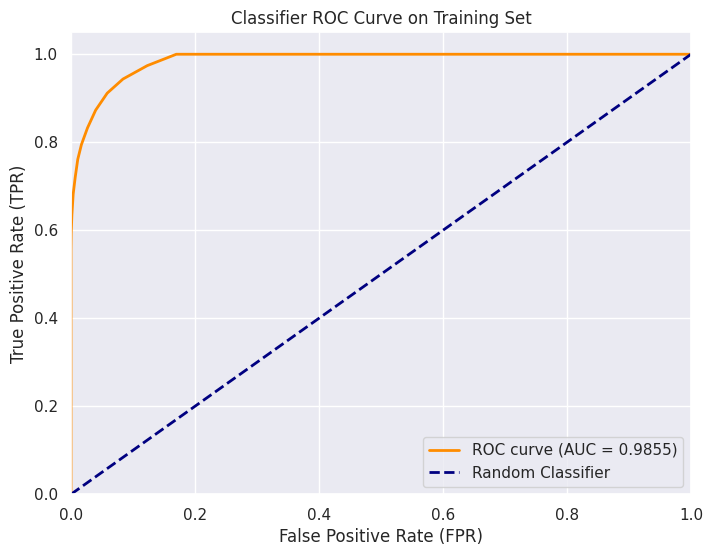

Training Set AUC: 0.9855


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_train_proba = best_model.predict_proba(X_train_scaled)[:, 1]

fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba)

auc_train = roc_auc_score(y_train, y_train_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_train:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Classifier ROC Curve on Training Set')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"Training Set AUC: {auc_train:.4f}")
